# Bayesian optimization

*Selected Topics in Mathematical Optimization: 2017-2018*

**Michiel Stock** ([email](michiel.stock@ugent.be))

![](Figures/logo.png)

In [1]:
import numpy as np
import sympy as sp
sp.init_printing()
from numpy import sin, exp, cos
from sklearn.preprocessing import normalize
from scipy.stats import norm
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
%matplotlib inline

In [2]:
np.random.seed(3)

In [3]:
blue = '#264653'
green = '#2a9d8f'
yellow = '#e9c46a'
orange = '#f4a261'
red = '#e76f51'
black = '#50514F'

## Motivation

**Goal**:

Solve 

$$
\mathbf{x}^* = \text{arg min}_\mathbf{x}\, f(\mathbf{x})
$$

when every evaluation of $f(\mathbf{x})$ is *expensive*.

**Example 1**:

*Dark art* of selecting the right hyperparameters for a machine learning model. Ditto for many optimization methods!

![Machine learning models often have many hyperparameters.](Figures/ANN_hyperpars.png)

**Example 2**:

*Model calibration* to find the right parameters or structure of a mechanistic model.

**Example 3**:

Experimentation for improvement (drug design, product development, new cooking recipes...):

1. Gather data
2. Make model
3. Select new experiments for testing in the lab
4. Repeat

## Leading example

Damped spring mass system.

![Spring with mass, damped](Figures/spring.png)

Model:

$$
m\ddot{y}(t) + \gamma \dot{y}(t) + k y(t) = 0\,,
$$

with:
- $m$: the mass (1 kg)
- $\gamma$: friction parameter (unknown)
- $k$: the spring constant (unknown)

Can be simulated (here exact solution known).

In [4]:
def damped_oscillator(t_vals, g, k, m=1, sigma=0, x0=1):
    if g**2 > 4*k*m:
        l1 = (-g**2 + (g**2 - 4*k*m)**0.5) / (2 * m)
        l2 = (-g**2 - (g**2 - 4*k*m)**0.5) / (2 * m)
        c1, c2 = np.linalg.solve([[1, 1], [l1, l2]], [[x0], [0]]).flatten()
        y_vals = c1 * exp(t_vals * l1) + c2 * exp(t_vals * l2)
    elif g**2 == 4*k*m:
        l1 = - g / (2 * m)
        c1, c2 = np.linalg.solve([[1, 0], [l1, 1]], [[x0], [0]]).flatten()
        y_vals = c1 * exp(t_vals * l1) + c2 * t_vals * exp(t_vals * l1)
    else:
        alpha = - g / (2 * m)
        beta = (4 * m * k - g**2)**0.5 / (2 * m)
        c1, c2 = np.linalg.solve([[1, 0], [alpha, beta]], [[x0], [0]]).flatten()
        y_vals = exp(alpha * t_vals) * (c1 * cos(beta * t_vals) + c2 * sin(beta * t_vals))
    return y_vals + np.random.randn(len(t_vals)) * sigma

Text(0,0.5,'$y(t)$')

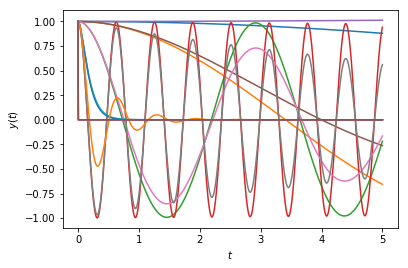

In [5]:
fig, ax = plt.subplots()

t_vals = np.linspace(0, 5, num = 1000)

for g in np.logspace(-2, 2, num=4):
    for k in np.logspace(-2, 2, num=4):
        y_vals = damped_oscillator(t_vals, g=g, k=k)
        ax.plot(t_vals, y_vals)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')

## Finding the best model parameters

We perform some experiments, and have 20 noisy measurements.

In [6]:
# parameters
m=1  # known
kstar=7  # unknown
gstar=1  # unknown

In [7]:
# noisy observations
t_meas = np.linspace(0, 5, num=20)
y_obs = damped_oscillator(t_meas, g=gstar, k=kstar, m=m, sigma=0.15)

In [8]:
# true function
t_vals = np.linspace(0, 5, num = 1000)
y_vals = damped_oscillator(t_vals, g=gstar, k=kstar, m=m)

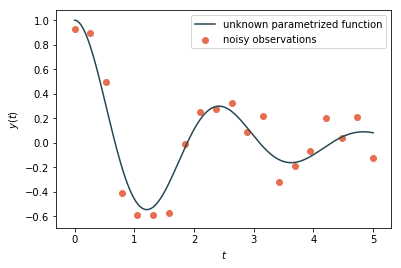

In [9]:
fig, ax = plt.subplots()

ax.plot(t_vals, y_vals, c=blue, label='unknown parametrized function')
ax.scatter(t_meas, y_obs, c=red, label='noisy observations')
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
ax.legend(loc=0)

For a given $\gamma$ and $k$, compute the mean squared error:

$$
MSE(\gamma, k) = \frac{1}{20} \sum_{i=1}^{20} (y(t_i) - \hat{y}(t_i, \gamma, k))^2
$$

Best parameters obtained by:

$$
\gamma^*, k^* = \text{arg min}_{\gamma, k} MSE(\gamma, k)
$$

In [10]:
def get_mse(g, k):
    """
    Computes the mean squared error for a given gamma and k.
    """
    y_sim = damped_oscillator(t_meas, g=g, k=k)
    return np.log10(np.mean((y_sim - y_obs)**2))

Since gamma and kappa are positive values for which we do not know the scale, it makes sense to work with the logarithm of these paramaters.

In [11]:
g_vals = np.logspace(-2, 2, num=100)
k_vals = np.logspace(-2, 2, num=100)

mse_pars = np.zeros((len(g_vals), len(k_vals)))
for i, g in enumerate(g_vals):
    for j, k in enumerate(k_vals):
        mse_pars[i, j] = get_mse(g=g, k=k)

Because the example is simple, we can search the complete space for the best parameters.

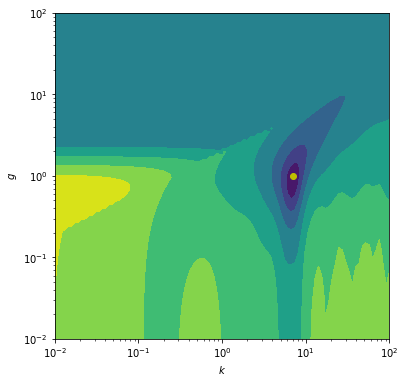

In [12]:
G, K = np.meshgrid(g_vals, k_vals)

fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(K, G, mse_pars.T)
ax.set_xlabel('$k$')
ax.set_ylabel('$g$')
ax.scatter(kstar, gstar, c='y')
ax.loglog()

In general, it is *not* possible to sample the whole parameter space. If the model is really complex, even a single evalutation might be expensive! What if we only can test a limited number of parameter combinations?

## Grid search vs. random search

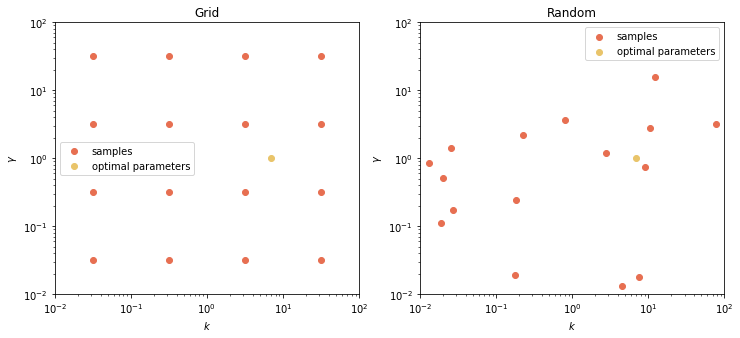

In [13]:
param_grid = np.array([[g, k] for k in np.logspace(-1.5, 1.5, num=4) for g in np.logspace(-1.5, 1.5, num=4)])
param_random = 10**np.random.uniform(-2, 2, size=(16, 2))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

ax0.scatter(param_grid[:,0], param_grid[:,1], c=red, label='samples')
ax0.set_title('Grid')

ax1.scatter(param_random[:,0], param_random[:,1], c=red, label='samples')
ax1.set_title('Random')

for ax in (ax1, ax0):
    ax.scatter(kstar, gstar, c=yellow, label='optimal parameters')
    ax.loglog()
    ax.set_xlabel('$k$')
    ax.set_ylabel('$\gamma$')
    ax.set_ylim([1e-2, 1e2])
    ax.set_xlim([1e-2, 1e2])
    ax.legend(loc=0)

> **Don't use grid search!**

In [14]:
# evaluate instances
simulated_parameters = param_random
#simulated_parameters = param_grid
mse_obs = np.array([get_mse(g=g, k=k) for g, k in simulated_parameters])
mse_obs

array([-0.8542471 , -0.46689791, -0.33187908, -0.85548296, -0.94725825,
       -0.27965313, -0.8541473 , -0.18839734, -0.85414733, -0.29718357,
       -0.24694029, -0.8541491 , -0.95694289, -0.01830113, -0.22508889,
       -0.9303206 ])

## Surrogate modelling with Gaussian processes

Predict the performance of *new* parameter combinations using a surrogate model.

(From here on onwards, $\mathbf{x}\in\mathcal{X}$ is used to denote the parameters)

Gaussian process:
- learn a function of the form $f: \mathcal{X}\rightarrow \mathbb{R}$
- nonlinear model, uses a positive-definite covariance function $K:\mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R}$
- Bayesian method: prior on function and use Bayes' theorem to condition on observed data
- can be updated if more date becomes available (online learning)
- fully probabilistic, in theory no tuning!

The model return for a given instance $\mathcal{x}$:

- $\mu(\mathbf{x})$: expected value;
- $\sigma(\mathbf{x})$: standard deviation.

For a brief, but well-founded overview of Gaussian processes, consult the [chapter](http://www.inference.org.uk/mackay/gpB.pdf) in the book of MacKay.

In [15]:
gaussian_process = GaussianProcessRegressor(alpha=1e-3)
# take logarithm of MSE and the parameters to obtain better scaling
gaussian_process.fit(np.log10(simulated_parameters), mse_obs)

GaussianProcessRegressor(alpha=0.001, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [16]:
instance = np.log10([[3, 0.1]])

mu, sigma = gaussian_process.predict(instance, return_std=True)
print('Predicted MSE: {} ({})'.format(mu[0], sigma[0]))

Predicted MSE: -0.8392304324239759 (0.34574779040748355)


Explore whole parameter space.

In [17]:
mu_mse = np.zeros_like(mse_pars)
std_mse = np.zeros_like(mse_pars)

for i, g in enumerate(g_vals):
    for j, k in enumerate(k_vals):
        instance = np.log10([[g, k]])
        mu, sigma = gaussian_process.predict(instance, return_std=True)
        mu_mse[i, j] = mu[:]
        std_mse[i, j] = sigma[:]

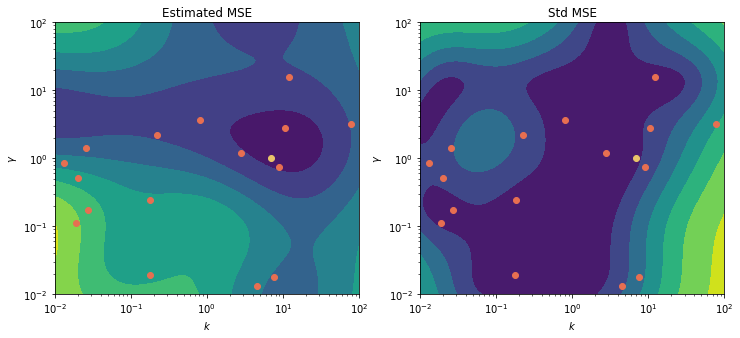

In [18]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))
ax0.contourf(K, G, mu_mse.T)
ax0.set_title('Estimated MSE')

ax1.contourf(K, G, std_mse.T)
ax1.set_title('Std MSE')

for ax in (ax0, ax1):
    ax.set_xlabel('$k$')
    ax.set_ylabel('$\gamma$')
    ax.loglog()
    ax.scatter(kstar, gstar, c=yellow)
    ax.scatter(simulated_parameters[:,0], simulated_parameters[:,1], c=red)

Slice for $k=1$.

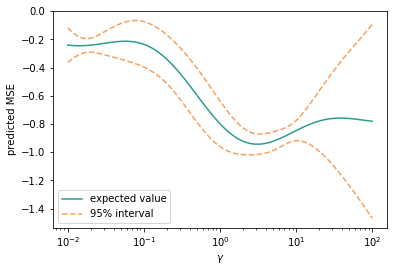

In [19]:
k_slice = np.column_stack((np.logspace(-2, 2, num=100), [1]*100))
# expected mse, std
mu, sigma = gaussian_process.predict(np.log10(k_slice), return_std=True)

fig, ax = plt.subplots()
ax.plot(k_slice[:,0], mu, c=green, label='expected value')
ax.plot(k_slice[:,0], mu-2*sigma, c=orange, ls='--', label='95% interval')
ax.plot(k_slice[:,0], mu+2*sigma, c=orange, ls='--')
ax.semilogx()
ax.set_xlabel('$\gamma$')
ax.set_ylabel('predicted MSE')
ax.legend(loc=0)

## Acquisition functions

How to choose points to simulate/test?

Acquisition function $a:\mathcal{X}\rightarrow\mathbb{R}^+$, determines how 'interesting' a point is to explore.

Choose

$$
\mathbf{x}_\text{next} = \text{arg max}_\mathbf{x} a(\mathbf{x})\,.
$$

Trade-off between *exploration* and *exploitation*.

**Probability of Improvement**

$$
a_\text{PI}(\mathbf{x}) = P(f(\mathbf{x})<f(\mathbf{x}_\text{best}) ) = \Phi(\gamma(\mathbf{x}))\,,
$$
with $\Phi(\cdot)$ the CDF of a standard normal distirbution and 
$$
\gamma(\mathbf{x})= \frac{f(x_\text{best}) - \mu(\mathbf{x})}{\sigma(\mathbf{x})}\,.
$$

In [20]:
def calculate_gamma(mu, sigma, fbest):
    return (fbest - mu) / sigma

def probability_improvement(mu, sigma, fbest=np.min(mse_obs)):
    """
    Calculates probability of improvement.
    """
    gamma_values = calculate_gamma(mu, sigma, fbest)
    return norm.cdf(gamma_values)

**Expected Improvement**

$$
a_\text{EI}(\mathbf{x}) = E[\max(f(\mathbf{x}) - f(\mathbf{x}_\text{best}), 0)] = \sigma(\mathbf{x})(\gamma(\mathbf{x})\Phi(\gamma(\mathbf{x})) + \phi(\gamma(\mathbf{x}))\,,
$$
with $\phi(\cdot)$ the PDF of a standard normal distirbution.

In [21]:
def expected_improvement(mu, sigma, fbest=np.min(mse_obs)):
    """
    Calculates expected improvement.
    """
    gamma_values = calculate_gamma(mu, sigma, fbest)
    return sigma * (gamma_values * norm.cdf(gamma_values) + norm.pdf(gamma_values))

**GP Lower Confidence Limit**

$$
a_\text{LCB} = \mu(\mathbf{x}) - \kappa \sigma(\mathbf{x})\,,
$$
with $\kappa$ a parameter determining the tightness of the bound.

In [22]:
def lower_confidence_bound(mu, sigma, kappa=2):
    """
    Calculates lower confidence bound.
    
    Made negative: maximizing acquisition function!
    """
    return - (mu - kappa * sigma)

In [23]:
def plot_acquisitions():
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, sharex=True, figsize=(8, 10))

    # plot mu and sigma
    ax0.plot(k_slice[:,0], mu, c=green, label='expected value')
    ax0.plot(k_slice[:,0], mu-2*sigma, c=orange, ls='--', label='95% interval')
    ax0.plot(k_slice[:,0], mu+2*sigma, c=orange, ls='--')
    ax0.semilogx()
    ax0.set_ylabel('predicted\nMSE')

    # plot information gains
    ax1.plot(k_slice[:,0], probability_improvement(mu, sigma), c=blue, label='PI')
    ax1.set_ylabel('PI')
    ax2.plot(k_slice[:,0], expected_improvement(mu, sigma), c=blue, label='EI')
    ax2.set_ylabel('EI')
    ax3.plot(k_slice[:,0], lower_confidence_bound(mu, sigma), c=blue, label='LCB')
    ax3.set_ylabel('LCB')
    ax3.set_xlabel('$\gamma$')


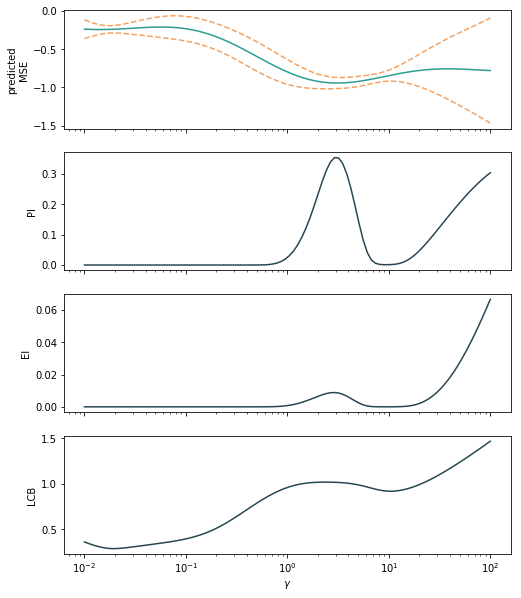

In [24]:
plot_acquisitions()

In [25]:
PI = np.zeros_like(mse_pars)
EI = np.zeros_like(mse_pars)
LCB = np.zeros_like(mse_pars)

for i, g in enumerate(g_vals):
    for j, k in enumerate(k_vals):
        instance = np.log10([[g, k]])
        mu, sigma = gaussian_process.predict(instance, return_std=True)
        mu = mu[:]
        sigma = sigma[:]
        PI[i,j] = probability_improvement(mu, sigma)
        EI[i,j] = expected_improvement(mu, sigma)
        LCB[i,j] = lower_confidence_bound(mu, sigma)

In [26]:
def show_acquisition_contourf(ax0, ax1, ax2):
    ax0.contourf(K, G, PI.T)
    ax0.set_title('PI')
    ax0.scatter(simulated_parameters[:,0], simulated_parameters[:,1], c=red)

    ax1.contourf(K, G, EI.T)
    ax1.set_title('EI')
    ax1.scatter(simulated_parameters[:,0], simulated_parameters[:,1], c=red)

    ax2.contourf(K, G, LCB.T)
    ax2.set_title('LCB')
    ax2.scatter(simulated_parameters[:,0], simulated_parameters[:,1], c=red)

    for ax in (ax0, ax1, ax2):
        ax.set_xlabel('$k$')
        ax.set_ylabel('$\gamma$')
        ax.loglog()
        ax.scatter(kstar, gstar, c=yellow)
        ax.scatter(simulated_parameters[:,0], simulated_parameters[:,1], c=red)

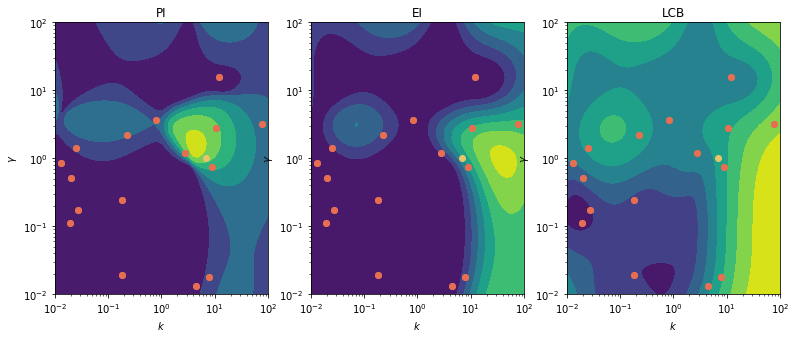

In [27]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(13, 5))
show_acquisition_contourf(ax0, ax1, ax2)

Use Gaussian process model to select new points to evaluate!

## Gradient-based optimization for finding next point

If we assume that evaluating points from the Gaussian process surogate model is much cheaper than evaluating the true function, we can either use an exhaustive sampling of this space (if the dimension is not too large) or use a gradient-based optimizer to find a maximizer of the acquisition function.

In [28]:
from scipy.optimize import minimize

In [29]:
neg_acquisition = lambda parameter : -probability_improvement(*gaussian_process.predict(parameter.reshape((1,2)),
                                                                                        return_std=True))

In [30]:
# start from best previous point
f0, x0 = min(zip(mse_obs, simulated_parameters))

result = minimize(neg_acquisition, x0=x0,
                  bounds=[(-2, 2), (-2, 2)])

xnew = result.x

result

     nfev: 18
      fun: array([-0.36629826])
   status: 0
        x: array([ 2.        ,  1.06184265])
  success: True
      jac: array([ -1.83551085e-01,  -1.02140518e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      nit: 5

In [31]:
print('New parameters to try: {}'.format(10**xnew))

New parameters to try: [ 100.           11.53035424]


## Concluding remarks

**Remark 1**

Gaussian process model usually continuous and differentiable w.r.t. $\mathbf{x}$:

- $\nabla \mu(\mathbf{x})$
- $\nabla \sigma(\mathbf{x})$

gradient-based optimization!

**Ramark 2**

Use of correlation between instances:

Text(0.5,1,'Covariance')

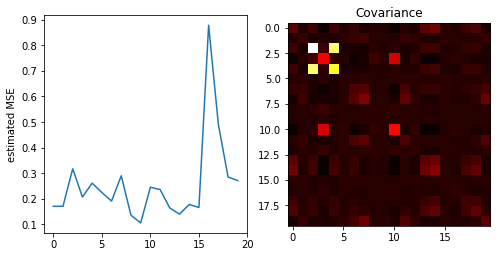

In [32]:
param_random = 10**np.random.uniform(-2, 2, size=(20, 2))

mu, cov = gaussian_process.predict(np.log10(param_random), return_cov=True)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4))
ax0.plot(10**mu)
ax0.set_ylabel('estimated MSE')

ax1.imshow(cov, interpolation='nearest', cmap='hot')
ax1.set_title('Covariance')

Use coviance to select a *set* of informative instances to explore!

**Remark 3**

Some instances will differ in execution times: 

- regularization size (machine learning)
- learning rate (machine learning)
- number of parameters
- grid size approximation (mechanistic modelling)

Better optimize *expected improvement per second*. Use a model of expected duration (second Gaussian process).

## References

Snoek, J., Larochelle, H., Adams, R. '*Practical Bayesian optimization of machine learning algorithms*'. Advances in Neural Information Processing Systems (2012)

Rasmussen, C., Williams, C., '*Gaussian Processes for Machine Learning*'. The MIT Press (2006)